In [1]:
import uproot
import numpy as np
import glob
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import h5py

from utils import *
from build_model import *

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
n_per_sample = 8000

with h5py.File('HHbbbb.h5', 'r') as f:
    X_HHbbbb_isHS = tf.cast(f['HS'][:n_per_sample], tf.float32)
    X_HHbbbb_isPU = tf.cast(f['PU'][:n_per_sample], tf.float32)

with h5py.File('PJZ0.h5', 'r') as f:
    X_PJZ0 = tf.cast(f['data'][:n_per_sample], tf.float32)

print(X_HHbbbb_isHS.shape)
print(X_HHbbbb_isPU.shape)
print(X_PJZ0.shape)

(8000, 64, 50, 6)
(8000, 64, 50, 6)
(8000, 64, 50, 6)


In [ ]:
plot_layers(event_idx=1, X=X_HHbbbb_isHS+X_HHbbbb_isPU, label='[HHbbbb, PU=200]')
plot_layers(event_idx=1, X=X_HHbbbb_isHS, label='[HHbbbb, PU=0]')
plot_layers(event_idx=2, X=X_PJZ0, label='[QCD dijet, PU=200]')

In [ ]:
target_pu = 100
x_augmented = augment_pu(image=X_HHbbbb_isPU[0], target_pu=target_pu, shift_phi=True)

plot_layers(event_idx=None, X=X_HHbbbb_isPU[0], label='[Pure PU, 200]')
plot_layers(event_idx=None, X=x_augmented, label=f'[Pure PU, aug. {target_pu}]')

## train vicreg

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 50, 6)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 50, 64)        3520      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 25, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               1651

Text(0, 0.5, 'Loss')

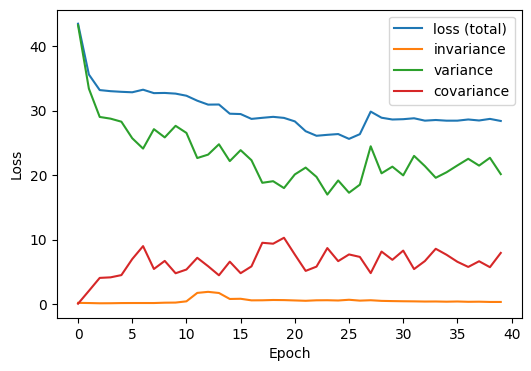

In [ ]:
batch_size = 2048
pu_min = 100
pu_max = 200
steps_per_epoch = (X_HHbbbb_isHS.shape[0] + X_PJZ0.shape[0]) // batch_size

gen_data_contrastive = generate_batch_for_contrastive(X_hs=X_HHbbbb_isHS,
                                                      X_pu=X_HHbbbb_isPU,
                                                      X_bkg=X_PJZ0,
                                                      pu_min=pu_min,
                                                      pu_max=pu_max,
                                                      batch_size=batch_size)

encoder = build_encoder(input_shape=input_shape, embedding_dim=embedding_dim)
projection_head = build_projection_head(embedding_dim=embedding_dim, projection_dim=projection_dim)

vicreg_model = VICRegModel(encoder=encoder, projection_head=projection_head, c_inv=c_inv, c_var=c_var, c_cov=c_cov)
vicreg_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005))

encoder.summary()
print('\n\n')
projection_head.summary()

history = vicreg_model.fit(gen_data_contrastive, steps_per_epoch=steps_per_epoch, epochs=40)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss (total)')
axes.plot(history.history['loss_inv'], label = 'invariance')
axes.plot(history.history['loss_var'], label = 'variance')
axes.plot(history.history['loss_cov'], label = 'covariance')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
#axes.set_yscale('log')
#axes.set_ylim((0.001, 100))

In [9]:
if os.path.exists('weights_encoder.h5'):
    os.remove('weights_encoder.h5')
    
if os.path.exists('weights_projection_head.h5'):
    os.remove('weights_projection_head.h5')

encoder.save_weights('weights_encoder.h5')
projection_head.save_weights('weights_projection_head.h5')

In [2]:
encoder_loaded = build_encoder(input_shape=input_shape, embedding_dim=embedding_dim)
encoder_loaded.load_weights('weights_encoder.h5')

projection_head_loaded = build_projection_head(embedding_dim=embedding_dim, projection_dim=projection_dim)
projection_head_loaded.load_weights('weights_projection_head.h5')

vicreg_model_loaded = VICRegModel(encoder=encoder_loaded,
                                  projection_head=projection_head_loaded,
                                  c_inv=c_inv,
                                  c_var=c_var,
                                  c_cov=c_cov)
#vicreg_model_loaded.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005))

## train embedding classifier

Epoch 1/20
15/15 [==============================] - 16s 1s/step - loss: 0.7765 - accuracy: 0.5294
Epoch 2/20
15/15 [==============================] - 16s 1s/step - loss: 0.5531 - accuracy: 0.7193
Epoch 3/20
15/15 [==============================] - 16s 1s/step - loss: 0.4681 - accuracy: 0.8423
Epoch 4/20
15/15 [==============================] - 17s 1s/step - loss: 0.4121 - accuracy: 0.8620
Epoch 5/20
15/15 [==============================] - 17s 1s/step - loss: 0.3645 - accuracy: 0.8777
Epoch 6/20
15/15 [==============================] - 17s 1s/step - loss: 0.3336 - accuracy: 0.8807
Epoch 7/20
15/15 [==============================] - 17s 1s/step - loss: 0.3167 - accuracy: 0.8831
Epoch 8/20
15/15 [==============================] - 17s 1s/step - loss: 0.2990 - accuracy: 0.8890
Epoch 9/20
15/15 [==============================] - 17s 1s/step - loss: 0.2911 - accuracy: 0.8874
Epoch 10/20
15/15 [==============================] - 17s 1s/step - loss: 0.2826 - accuracy: 0.8878
Epoch 11/20
15/15 [

Text(0, 0.5, 'Loss')

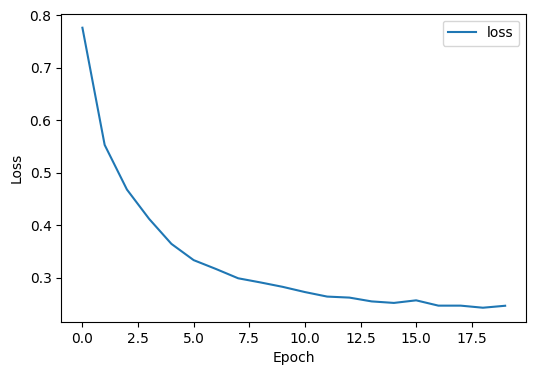

In [5]:
batch_size = 1024
pu_min = 120
pu_max = 121
steps_per_epoch = (X_HHbbbb_isHS.shape[0] + X_PJZ0.shape[0]) // batch_size

gen_data_classification = generate_batch_for_classifier(X_hs=X_HHbbbb_isHS,
                                                        X_pu=X_HHbbbb_isPU,
                                                        X_bkg=X_PJZ0,
                                                        pu_min=pu_min,
                                                        pu_max=pu_max,
                                                        batch_size=batch_size)

embedding_classifier = build_embedding_classifier(encoder=encoder_loaded, input_shape=input_shape)
embedding_classifier.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

history = embedding_classifier.fit(gen_data_classification, steps_per_epoch=steps_per_epoch, epochs=20)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [6]:
if os.path.exists('weights_embedding_classifier.h5'):
    os.remove('weights_embedding_classifier.h5')

embedding_classifier.save_weights('weights_embedding_classifier.h5')

In [3]:
encoder_loaded = build_encoder(input_shape=input_shape, embedding_dim=embedding_dim)
encoder_loaded.load_weights('weights_encoder.h5')

embedding_classifier_loaded = build_embedding_classifier(encoder=encoder_loaded, input_shape=input_shape)
embedding_classifier_loaded.load_weights('weights_embedding_classifier.h5')

## train standalone classifier

Epoch 1/20
15/15 [==============================] - 19s 1s/step - loss: 0.6686 - accuracy: 0.5017
Epoch 2/20
15/15 [==============================] - 19s 1s/step - loss: 0.4472 - accuracy: 0.8463
Epoch 3/20
15/15 [==============================] - 19s 1s/step - loss: 0.1784 - accuracy: 0.9448
Epoch 4/20
15/15 [==============================] - 20s 1s/step - loss: 0.1459 - accuracy: 0.9492
Epoch 5/20
15/15 [==============================] - 20s 1s/step - loss: 0.1314 - accuracy: 0.9530
Epoch 6/20
15/15 [==============================] - 20s 1s/step - loss: 0.1235 - accuracy: 0.9567
Epoch 7/20
15/15 [==============================] - 20s 1s/step - loss: 0.1146 - accuracy: 0.9589
Epoch 8/20
15/15 [==============================] - 20s 1s/step - loss: 0.1173 - accuracy: 0.9592
Epoch 9/20
15/15 [==============================] - 20s 1s/step - loss: 0.1286 - accuracy: 0.9542
Epoch 10/20
15/15 [==============================] - 20s 1s/step - loss: 0.1287 - accuracy: 0.9561
Epoch 11/20
15/15 [

Text(0, 0.5, 'Loss')

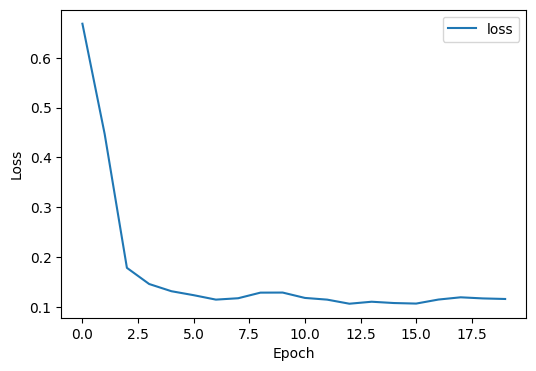

In [7]:
batch_size = 1024
pu_min = 120
pu_max = 121
steps_per_epoch = (X_HHbbbb_isHS.shape[0] + X_PJZ0.shape[0]) // batch_size

gen_data_classification = generate_batch_for_classifier(X_hs=X_HHbbbb_isHS,
                                                        X_pu=X_HHbbbb_isPU,
                                                        X_bkg=X_PJZ0,
                                                        pu_min=pu_min,
                                                        pu_max=pu_max,
                                                        batch_size=batch_size)

standalone_classifier = build_standalone_classifier(input_shape=input_shape)
standalone_classifier.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

history = standalone_classifier.fit(gen_data_classification, steps_per_epoch=steps_per_epoch, epochs=20)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [8]:
if os.path.exists('weights_standalone_classifier.h5'):
    os.remove('weights_standalone_classifier.h5')

standalone_classifier.save_weights('weights_standalone_classifier.h5')

In [4]:
standalone_classifier_loaded = build_standalone_classifier(input_shape=input_shape)
standalone_classifier_loaded.load_weights('weights_standalone_classifier.h5')

## evaluate

In [5]:
n_per_sample = 10000

with h5py.File('HHbbbb.h5', 'r') as f:
    X_HHbbbb_isHS = tf.cast(f['HS'][-n_per_sample:], tf.float32)
    X_HHbbbb_isPU = tf.cast(f['PU'][-n_per_sample:], tf.float32)

with h5py.File('PJZ0.h5', 'r') as f:
    X_PJZ0 = tf.cast(f['data'][-n_per_sample:], tf.float32)

print(X_HHbbbb_isHS.shape)
print(X_HHbbbb_isPU.shape)
print(X_PJZ0.shape)

(10000, 64, 50, 6)
(10000, 64, 50, 6)
(10000, 64, 50, 6)


In [10]:
test_pu = list(range(100, 201, 20))
X_test = []
Y_test = []
Y_pred_embedding = []
Y_pred_standalone = []
for pu in test_pu:
    x, y = generate_dataset_for_classifier(X_hs=X_HHbbbb_isHS, X_pu=X_HHbbbb_isPU, X_bkg=X_PJZ0, target_pu=pu)
    X_test.append(x)
    Y_test.append(y)

    Y_pred_embedding.append(embedding_classifier_loaded.predict(x))
    Y_pred_standalone.append(standalone_classifier_loaded.predict(x))
    print(pu)

625/625 [==============================] - 5s 7ms/step
100
625/625 [==============================] - 5s 7ms/step
120
625/625 [==============================] - 5s 7ms/step
140
625/625 [==============================] - 5s 8ms/step
160
625/625 [==============================] - 5s 8ms/step
180
625/625 [==============================] - 5s 8ms/step
200


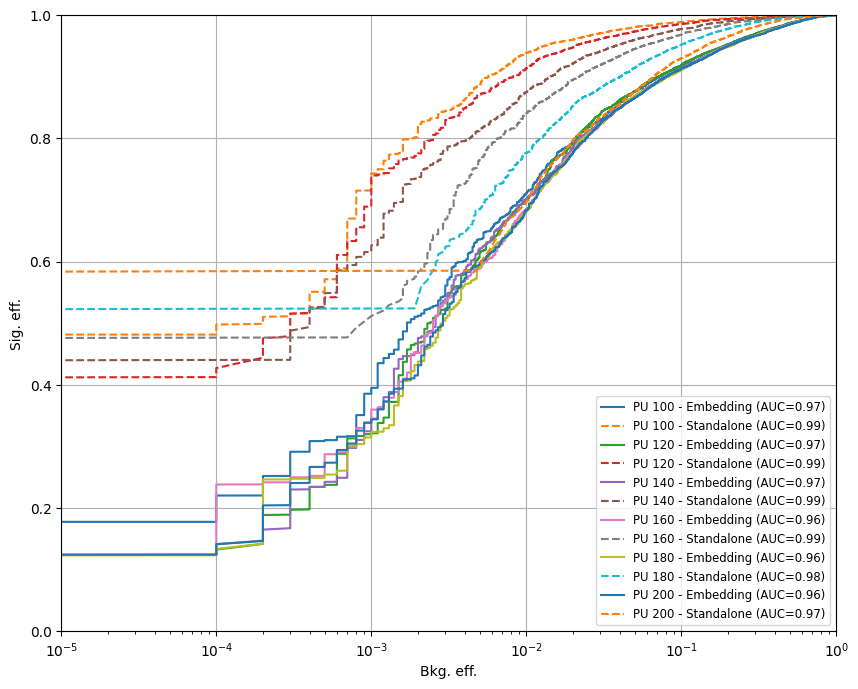

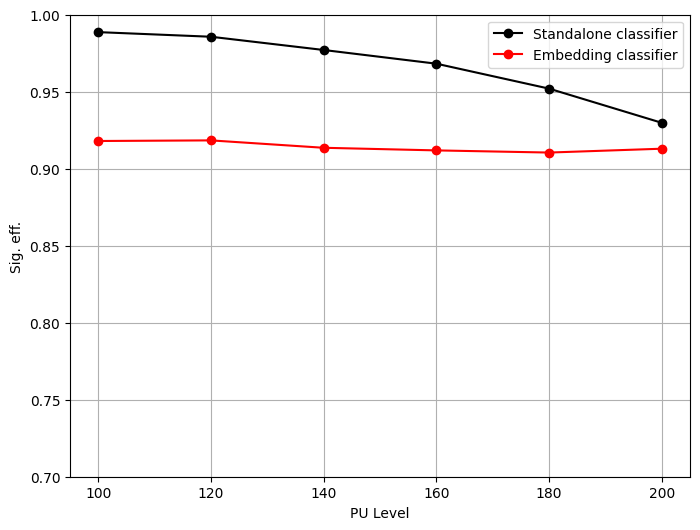

In [ ]:
def plot_roc(Y_test, Y_pred_embedding, Y_pred_standalone, test_pu):
    plt.figure(figsize=(10,8))
    
    for i, pu in enumerate(test_pu):
        y_true = Y_test[i]
        y_pred_embed = Y_pred_embedding[i]
        fpr_embed, tpr_embed, _ = roc_curve(y_true, y_pred_embed)
        auc_embed = auc(fpr_embed, tpr_embed)
        
        y_pred_stand = Y_pred_standalone[i]
        fpr_stand, tpr_stand, _ = roc_curve(y_true, y_pred_stand)
        auc_stand = auc(fpr_stand, tpr_stand)
        
        plt.plot(fpr_embed, tpr_embed, 
                 label=f'PU {pu} - Embedding (AUC={auc_embed:.2f})',
                 linestyle='-', marker=None)
        
        plt.plot(fpr_stand, tpr_stand, 
                 label=f'PU {pu} - Standalone (AUC={auc_stand:.2f})',
                 linestyle='--', marker=None)
    
    plt.xlabel('Bkg. eff.')
    plt.ylabel('Sig. eff.')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    #plt.yscale('log')
    plt.xscale('log')
    plt.xlim((0.00001, 1))
    plt.ylim((0, 1))
    plt.show()

def plot_sig_eff_vs_pu(Y_test, Y_pred_embedding, Y_pred_standalone, test_pu, bkg_eff=0.1):
    signal_eff_embed = []
    signal_eff_stand = []
    
    for i, pu in enumerate(test_pu):
        y_true = Y_test[i]
        
        y_pred_embed = Y_pred_embedding[i].ravel()
        fpr_embed, tpr_embed, _ = roc_curve(y_true, y_pred_embed)
        idx_embed = np.argmin(np.abs(fpr_embed - bkg_eff))
        signal_eff_embed.append(tpr_embed[idx_embed])
        
        y_pred_stand = Y_pred_standalone[i].ravel()
        fpr_stand, tpr_stand, _ = roc_curve(y_true, y_pred_stand)
        idx_stand = np.argmin(np.abs(fpr_stand - bkg_eff))
        signal_eff_stand.append(tpr_stand[idx_stand])
    
    plt.figure(figsize=(8,6))
    plt.plot(test_pu, signal_eff_stand, marker='o', color='black', linestyle='-', label='Standalone classifier')
    plt.plot(test_pu, signal_eff_embed, marker='o', color='red', linestyle='-', label='Embedding classifier')
    plt.xlabel('PU Level')
    plt.ylabel('Sig. eff.')
    plt.ylim((0.7,1))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc(Y_test=Y_test, Y_pred_embedding=Y_pred_embedding, Y_pred_standalone=Y_pred_standalone, test_pu=test_pu)
plot_sig_eff_vs_pu(Y_test=Y_test, Y_pred_embedding=Y_pred_embedding, Y_pred_standalone=Y_pred_standalone, test_pu=test_pu, bkg_eff=0.1)